may 2023 exam

In [30]:
from skimage import io, color
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import pydicom as dicom

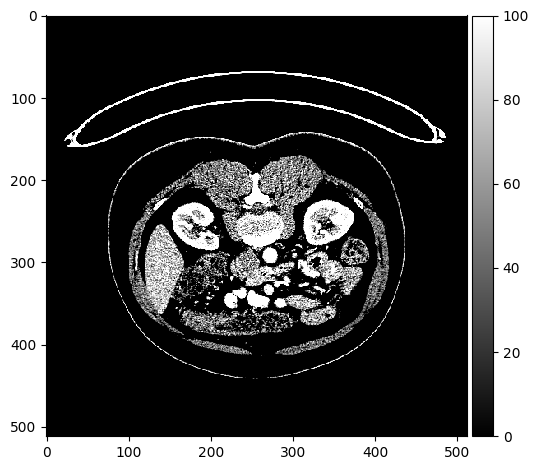

107.45075421472937 107.56182572614108
limits: 51.7968823111612, 100.87099317992372


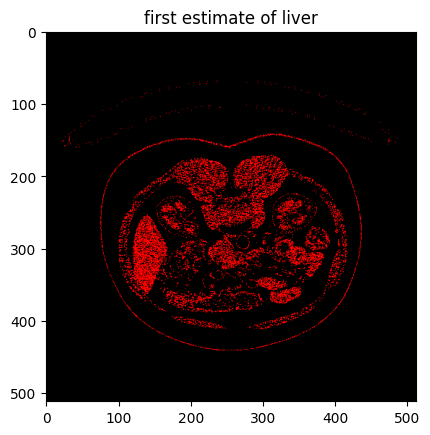

In [32]:
dcm = dicom.read_file('./may2023/data/Abdominal/1-166.dcm')
img = dcm.pixel_array #extract pixel data, already hounsfield units -> its the format for dicom images
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

#extract pixel values
liver_roi = io.imread('./may2023/data/Abdominal/LiverROI.png')
liver_mask = liver_roi > 0 #white values
liver_values = img[liver_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )

rk_roi = io.imread('./may2023/data/Abdominal/KidneyRoi_r.png')
rk_mask = rk_roi > 0 #white values
rk_values = img[rk_roi] #spleen values contain the HU values

lk_roi = io.imread('./may2023/data/Abdominal/KidneyRoi_l.png')
lk_mask = lk_roi > 0 #white values
lk_values = img[lk_mask] #spleen values contain the HU values

lk_avg = np.average(lk_values)
rk_avg = np.average(rk_values)
print(lk_avg, rk_avg) #super small difference

mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

threshold_1 = mu_liver - std_liver
threshold_2 = mu_liver + std_liver
print(f"limits: {threshold_1}, {threshold_2}")

bin_im = (img > threshold_1) & (img < threshold_2)
liver_label_color = color.label2rgb(bin_im)
plt.imshow(liver_label_color)
plt.title("first estimate of liver")
plt.show()


In [22]:
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import disk
from skimage import measure, io
from scipy.spatial import distance

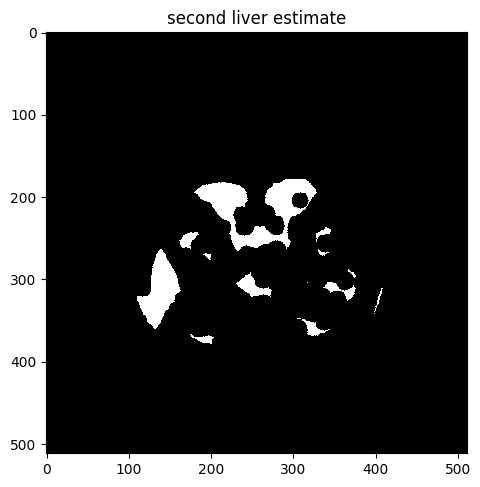

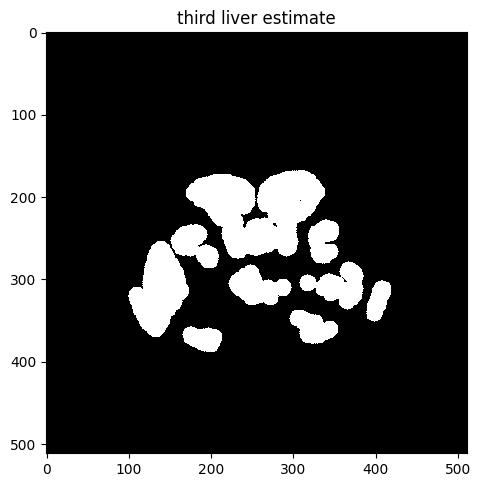

In [37]:
footprint = disk(3)
dilated1 = binary_dilation(bin_im, footprint)
footprint = disk(10)
eroded = binary_erosion(dilated1, footprint)
io.imshow(eroded)
plt.title("second liver estimate")
io.show()
dilated2 = binary_dilation(eroded, footprint)
io.imshow(dilated2)
plt.title("third liver estimate")
io.show()


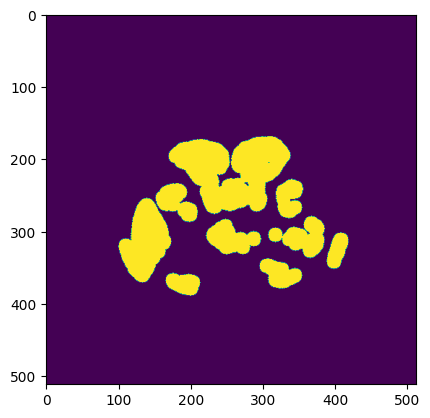

Number of labels: 9


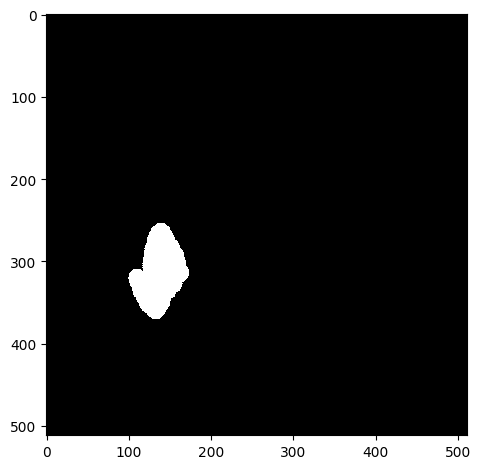

In [41]:
plt.imshow(dilated2)
plt.show()

label_img = measure.label(dilated2)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

max_area = 7000
min_area = 1500
max_perim = 300

label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    perimeter = region.perimeter
    if area < min_area or area > max_area or perimeter < max_perim:
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0

new_blobs_image = label_img_filter > 0
io.imshow(new_blobs_image)
io.show()

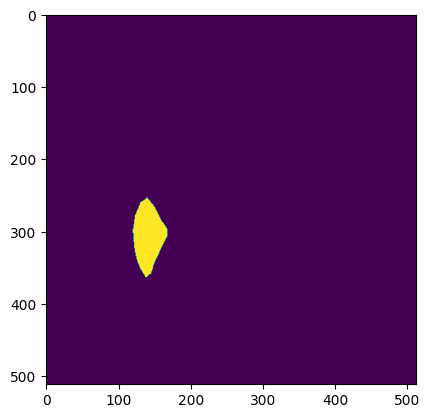

DICE score 0.783


In [42]:
liverGT = liver_roi
plt.imshow(liver_roi)
plt.show()

gt_bin = liver_roi > 0
dice_score = 1 - distance.dice(new_blobs_image.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score:.3f}")

In [52]:
#glass analysis
glass_data = np.loadtxt('./may2023/data/GlassPCA/glass_data.txt', comments="%")
x = glass_data
n_feat = x.shape[1]
n_obs = x.shape[0]

mean = np.mean(x, axis = 0)  #computes mean of each feature
data = x - mean

min = np.min(data, axis = 0 )
print(min)
max = np.max(data, axis = 0 )
print(max)

diff = max - min
data = data/ diff
print(f"sodium -> {data[0][1]}")
#PCA
cov_data = np.cov(data.T) 
values, vectors = np.linalg.eig(cov_data)
v_norm = values / values.sum() * 100
answer = v_norm[0] + v_norm[1] + v_norm[2]
print(f"Answer: Variance explained by the first four PC: {answer:.2f}")



[-0.00721542 -2.67785047 -2.68453271 -1.15490654 -2.84093458 -0.49705607
 -3.52696262 -0.17504673 -0.05700935]
[0.01556458 3.97214953 1.80546729 2.05509346 2.75906542 5.71294393
 7.23303738 2.97495327 0.45299065]
sodium -> 0.034909704166959016
Answer: Variance explained by the first four PC: 76.07


In [49]:
print(cov_data[0][0])

0.017772281053790966


In [56]:
pc_proj = vectors.T.dot(data.T)
print(pc_proj)
pc_proj_abs = np.abs(pc_proj)
max_value = np.max(pc_proj_abs)
#sum_sq = np.sum(first_proj ** 2)
print(f"Answer: max abs val {max_value:.2f}")

[[ 0.40210641  0.20631979  0.188617   ... -0.73947698 -0.72370373
  -0.74101123]
 [ 0.0327067  -0.14470531 -0.1948536  ... -0.14151154 -0.22855798
  -0.21472512]
 [ 0.16705036  0.08192307  0.04469616 ...  0.00193456 -0.02649169
  -0.04000224]
 ...
 [-0.05262549 -0.0026443  -0.04663113 ...  0.02334397  0.04201111
   0.0146114 ]
 [ 0.01378786  0.04461175  0.00435341 ... -0.18835071 -0.16156005
  -0.18443497]
 [ 0.04276046  0.0358561   0.00448895 ...  0.21339296  0.22455072
   0.19572056]]
Answer: max abs val 1.12


In [67]:
import SimpleITK as sitk
from math import radians

In [69]:
def rotation_matrix(pitch, roll, yaw):
    """
    Returns the rotation matrix for given roll, pitch, and yaw angles.
    """
    cos_pitch = np.cos(pitch)
    sin_pitch = np.sin(pitch)
    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # Define the rotation matrix for pitch, roll, and yaw
    R_pitch = np.array(
        [[1, 0, 0], [0, cos_pitch, -sin_pitch], [0, sin_pitch, cos_pitch]],
    )

    R_roll = np.array([[cos_roll, 0, sin_roll], [0, 1, 0], [-sin_roll, 0, cos_roll]])

    R_yaw = np.array([[cos_yaw, -sin_yaw, 0], [sin_yaw, cos_yaw, 0], [0, 0, 1]])

    # Combine the rotation matrices to obtain the final rotation matrix
    rotation_matrix = np.dot(R_yaw, np.dot(R_pitch, R_roll))
    return rotation_matrix

yaw_rad = radians(10)
roll_rad = radians(30)
mat = rotation_matrix(0, roll_rad, yaw_rad)
print(mat)

# Get the rotation matrix for the given pitch angle and zero roll and yaw

affine_matrix = np.eye(4)

affine_matrix[:3, :3] = mat

# Create an affine transform
transform = sitk.AffineTransform(3)  # 3D transformation

# Set the rotation matrix to the affine transform
transform.SetMatrix(mat.flatten())
transform.SetTranslation((10, 0, 0))


# convert the transformation to a homogeneous matrix
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""

    matrix = np.zeros((4, 4))

    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))

    matrix[:3, 3] = transform.GetTranslation()

    matrix[3, 3] = 1

    return matrix



hom_mat = homogeneous_matrix_from_transform(transform)
hom_mat

[[ 0.85286853 -0.17364818  0.49240388]
 [ 0.15038373  0.98480775  0.08682409]
 [-0.5         0.          0.8660254 ]]


array([[ 0.85286853, -0.17364818,  0.49240388, 10.        ],
       [ 0.15038373,  0.98480775,  0.08682409,  0.        ],
       [-0.5       ,  0.        ,  0.8660254 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [71]:
from skimage.morphology import binary_dilation
from skimage.morphology import disk

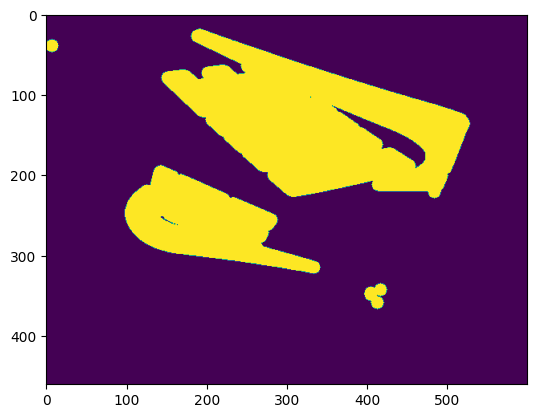

foreground pix = 58979 


In [79]:
img = io.imread("./may2023/data/Pixelwise/nike.png")
hsv_img1 = color.rgb2hsv(img)
h_img1 = (hsv_img1[:, :, 0])
bin_im = ( h_img1 > 0.3) & (h_img1 < 0.7)

footprint = disk(8)
dilated = binary_dilation(bin_im, footprint)

plt.imshow(dilated)
plt.show()
print(f"foreground pix = {np.sum(dilated)} ")


In [83]:
old_shoe = io.imread("./may2023/data/LMRegistration/shoe_1.png") #src
new_shoe = io.imread("./may2023/data/LMRegistration/shoe_2.png") #dst

from skimage.transform import EuclideanTransform, matrix_transform
from skimage.transform import SimilarityTransform

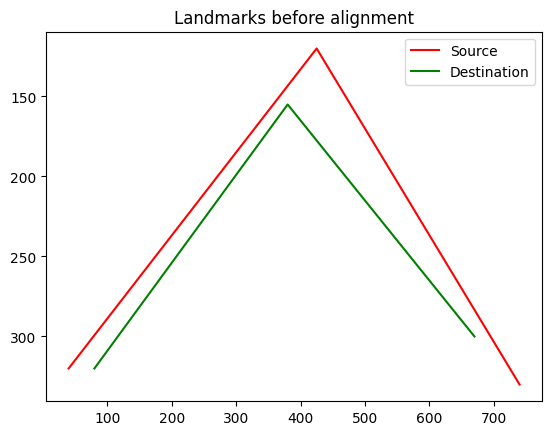

Landmark alignment error F (sum of squared differences): 10650
scale of transform = 0.83
[[ 78.96488773 327.99975659]
 [389.63670663 143.61437352]
 [661.39840565 303.3858699 ]]
Landmark alignment error F (sum of squared differences): 373.0177082699462


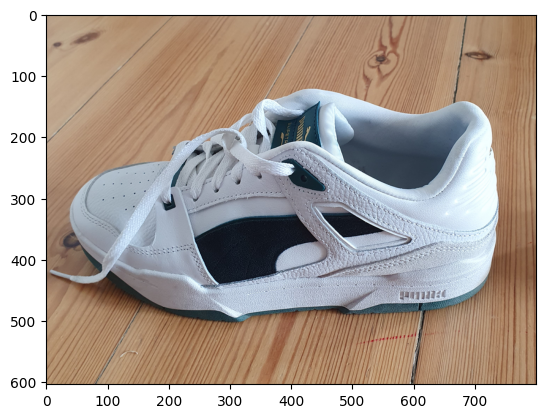

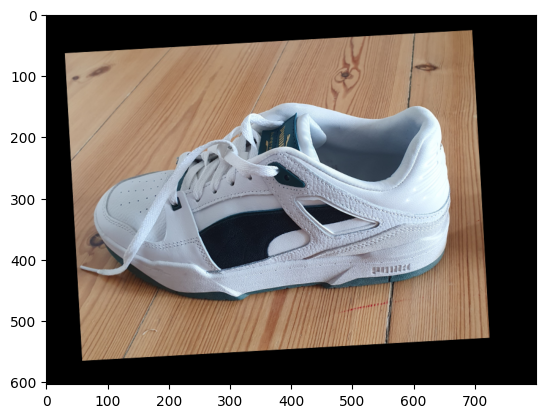

value on warped -> [176 141 113]
value on new_shoe -> [186 161 139]


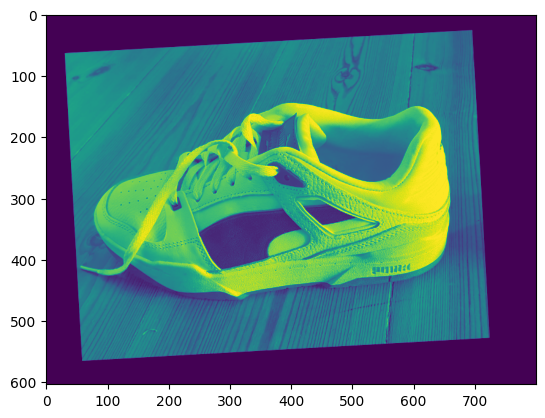

value on warped -> 113
value on new_shoe -> 139
Answer: blue difference 26


In [103]:
src = np.array(([40, 320], [425, 120], [740, 330]))
dst = np.array(([80, 320], [380, 155], [670, 300]))


fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F (sum of squared differences): {f}")

tform = SimilarityTransform()
tform.estimate(src, dst)
print(f"scale of transform = {tform.scale:.2f}")

src_transform = matrix_transform(src, tform.params) #similarity transform in numpy array format
print(src_transform)

e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f_after = error_x + error_y
print(f"Landmark alignment error F (sum of squared differences): {f_after}")

warped_im = warp(old_shoe, tform.inverse)
plt.imshow(old_shoe)
plt.show()
plt.imshow(warped_im)
plt.show()


w_im  = img_as_ubyte(warped_im)
ns_im = img_as_ubyte(new_shoe)
print(f"value on warped -> {w_im[200][200]}")
print(f"value on new_shoe -> {ns_im[200][200]}")


w_im_b =  w_im[:, :, 2]
ns_im_b = ns_im[:, :, 2]
plt.imshow(w_im_b)
plt.show()
val_1_b = w_im_b[200][200]
val_2_b = ns_im_b[200][200]
print(f"value on warped -> {val_1_b}")
print(f"value on new_shoe -> {val_2_b}")

diff = 113 - 139
print(f"Answer: blue difference {np.abs(diff)}")


In [105]:
diff_alignemnt = f - f_after
diff_alignemnt

10276.982291730053

In [110]:
#video change detection
bg_im = io.imread("./may2023/data/ChangeDetection/background.png")
new_frame = io.imread("./may2023/data/ChangeDetection/new_frame.png")
#they are both RGB images of size (600, 450).

bg_gray = color.rgb2gray(bg_im)
new_frame_gray = color.rgb2gray(new_frame)
alpha = 0.90
new_background = alpha * bg_gray + (1- alpha) * new_frame_gray

diff_im = np.abs(new_frame_gray - new_background)

bin_im = (diff_im > 0.1)
changed_pixels = np.sum(bin_im)
print(changed_pixels)

bg_region = new_background[150:200, 150:200]
avg_val = np.average(bg_region)
avg_val

25764


0.6024177409725491

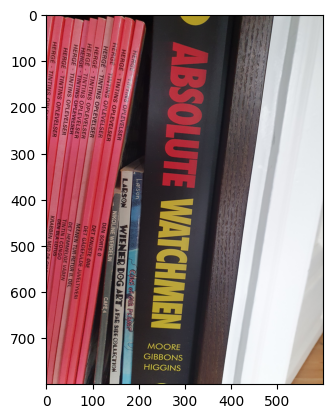

pixels = 36073


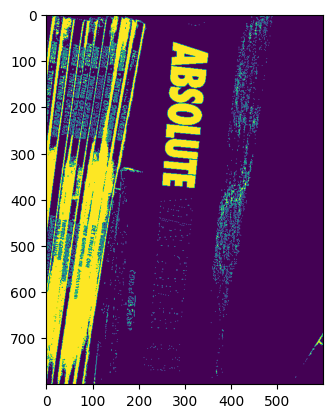

In [115]:
#character recognition
letters = io.imread("./may2023/data/Letters/Letters.png")
plt.imshow(letters)
plt.show()
r_letters = letters[:, :, 0]
g_letters = letters[:, :, 1]
b_letters = letters[:, :, 2]
#extarct red,g anfd b channels
bin_letters = (r_letters > 100) & (g_letters < 100) & ( b_letters < 100)
plt.imshow(bin_letters)

footprint = disk(3)
eroded = binary_erosion(bin_letters, footprint)

print(f"pixels = {np.sum(eroded)}")

In [119]:
from skimage.filters import median

In [121]:
letters = io.imread("./may2023/data/Letters/Letters.png")
grayscale = color.rgb2gray(letters)

size = 8
footprint = np.ones([size, size])
med_img = median(grayscale, footprint)

pix_100 = med_img[100, 100]
print(pix_100)


0.44944431372549015


"\ndef apply_median_filter(img, size):\n    footprint = np.ones([size, size])\n    med_img = median(img, footprint)\n    return med_img\n\nmedian5 = apply_median_filter(im_org, size = 5)\nmedian10 = apply_median_filter(im_org, size = 10)\nmedian20 = apply_median_filter(im_org, size = 20)\nmedian40 = apply_median_filter(im_org, size = 30)\n\nfig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))\nax[0].imshow(median5, cmap = 'gray')\nax[1].imshow(median10, cmap = 'gray')\nax[2].imshow(median20, cmap = 'gray')\nax[3].imshow(median40, cmap = 'gray')\nplt.show()\n\n"

Number of labels: 156


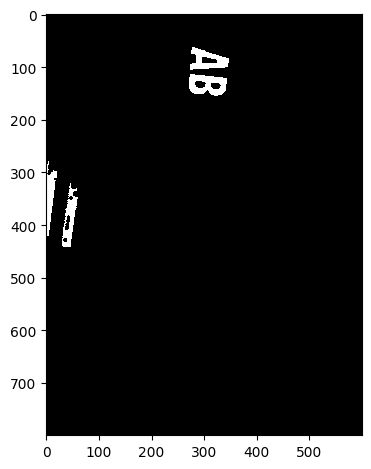

In [125]:
label_img = measure.label(eroded)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

max_area = 4000
min_area = 1000

label_img_filter = label_img.copy()
for region in region_props:
    area  = region.area
    perim = region.perimeter
    if area < min_area or area > max_area or perim < 300:
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0



#create new bin image with the filtered label image -> should only have the relevant blobs
i_letters = label_img_filter > 0
io.imshow(i_letters)
io.show()


In [137]:
im_size = 3 * 1600 * 800 #bytes per image
time_for_frame = 230 * 10**-3 #seconds per frame
im_per_sec = 6.25
transf_speed = im_size / im_per_sec  #24 * 10**6 #bytes per second

frame_rate = transf_speed / im_size
#frame_rate
processed_per_second = 1 / time_for_frame
print(frame_rate)
print(processed_per_second) #<- is the max amaount that can be transferred


0.16
4.3478260869565215


In [142]:
import glob
from sklearn import decomposition

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

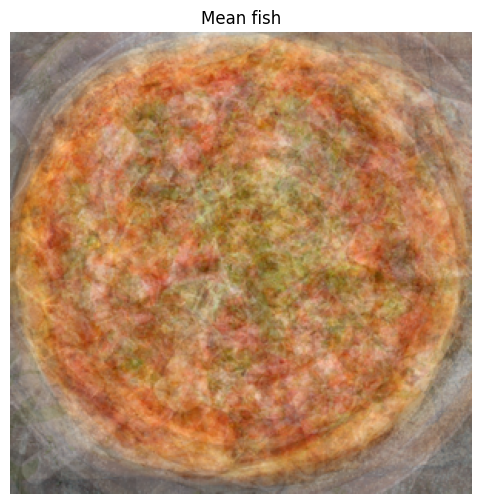

In [144]:
#PizzaPCA
dir = "./may2023/data/PizzaPCA/training" #all_images

files = glob.glob(f"{dir}/*.png")
height, width, channels = io.imread(files[0]).shape

data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()
average_pizza = np.mean(data_matrix, axis=0)

average_pizza_img = create_u_byte_image_from_vector(average_pizza, height, width, channels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_pizza_img)
ax.set_title("Mean pizza")
ax.set_axis_off()
plt.show()


In [146]:
pizza_pca = PCA(n_components=5)
pizza_pca.fit(data_matrix)

PCA(n_components=5)

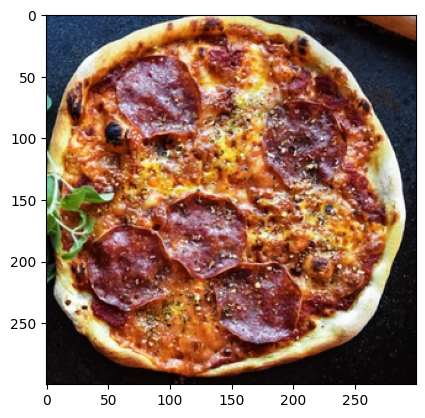

In [156]:
im_average_flat = average_pizza_img.reshape(1, -1)
pca_coords = pizza_pca.transform(im_average_flat)
pca_coords = pca_coords.flatten()

components = pizza_pca.transform(data_matrix)
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
worst_match = np.argmax(pca_distances) #most different fish
most_diff_pizza_ = data_matrix[worst_match, :]

worst_pizza_im = create_u_byte_image_from_vector(most_diff_pizza_, height, width, channels)
plt.imshow(worst_pizza_im)
plt.show()
#bigsausage pizza

In [159]:
explained_variance = pizza_pca.explained_variance_ratio_
print(explained_variance[0])


0.2308278699068841


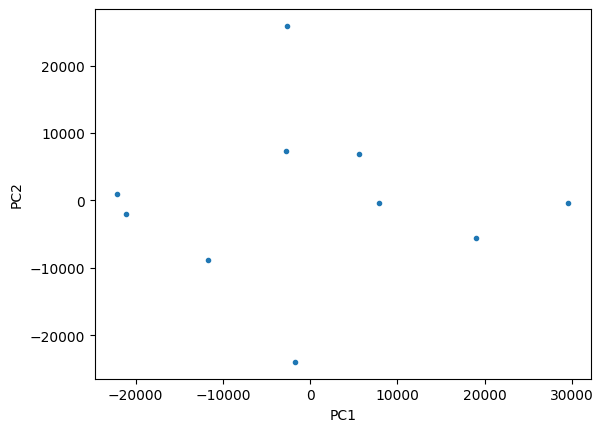

'./may2023/data/PizzaPCA/training/FindTheOlives.png'

In [164]:
#projecting onto first 2 principal components:
pc_1 = components[:, 0]
pc_2 = components[:, 1]

plt.plot(pc_1, pc_2, '.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

max_index = np.argmax(pc_1)
min_index = np.argmin(pc_1)

neg_pizza = files[min_index]
pos_pizza = files[max_index]

neg_pizza


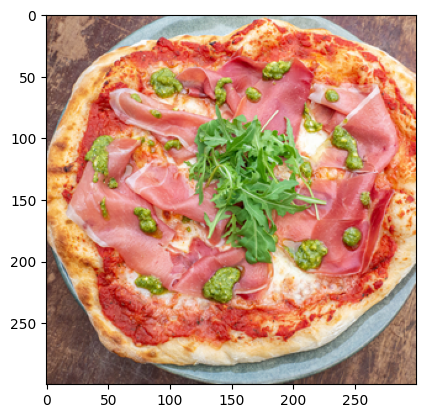

In [170]:
super_pizza = io.imread("./may2023/data/PizzaPCA/super_pizza.png")
#find most similar
super_pizza = super_pizza.flatten()
im_favourite_flat = super_pizza.reshape(1, -1)
superpizza_pca_coords = pizza_pca.transform(im_favourite_flat)
superpizza_pca_coords = superpizza_pca_coords.flatten()

comp_sub = components - superpizza_pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
best_match = np.argmin(pca_distances) #most similar pizza
best_matching_pizza = data_matrix[best_match, :]

best_pizza_im = create_u_byte_image_from_vector(best_matching_pizza, height, width, channels)
plt.imshow(best_pizza_im)
plt.show()

In [184]:
import matplotlib.pyplot as plt
import math
import numpy as np
import skimage.io as io
from skimage.util import img_as_float, img_as_uint
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.transform import swirl
from skimage.transform import matrix_transform

def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap = "gray")
    ax1.set_title("Original")
    ax1.axis("off")
    ax2.imshow(transformed, cmap = "gray")
    ax2.set_title(transformed_name)
    ax2.axis("off")
    io.show()

from skimage.filters import threshold_otsu

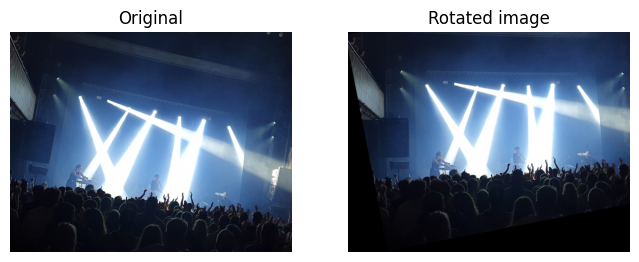

In [193]:
im_org = io.imread("./may2023/data/GeomTrans/lights.png")

rotation_angle = 11
rotated_img = rotate(im_org, rotation_angle, center = [40, 40])
show_comparison(im_org, rotated_img, "Rotated image")

0.419921875


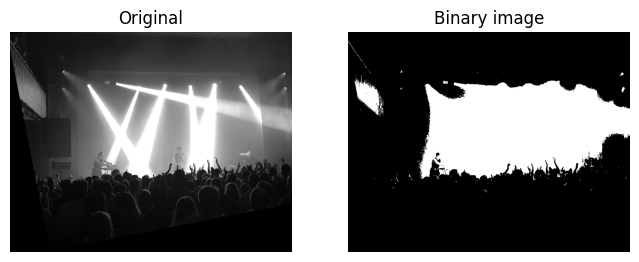

Answer: foreground pixels percent: 26


In [199]:
lights_gray = color.rgb2gray(rotated_img)

thresh = threshold_otsu(lights_gray)
print(thresh)
lights_bin = lights_gray > thresh 
show_comparison(lights_gray, lights_bin, 'Binary image')

for_percent = lights_bin.sum() / lights_bin.size * 100
print(f"Answer: foreground pixels percent: {for_percent:.0f}")